In [1]:
import torch
import models_vit
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, auc

from pathlib import  Path
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from util.pos_embed import interpolate_pos_embed
from timm.models.layers import trunc_normal_
from torch.nn import Linear,ReLU,CrossEntropyLoss


In [2]:
# call the model
model_R = models_vit.__dict__['vit_large_patch16'](
    num_classes=2,
    drop_path_rate=0.2,
    global_pool=True,
)

# load RETFound weights
checkpoint = torch.load('RETFound_cfp_weights.pth', map_location='cpu')
checkpoint_model = checkpoint['model']
state_dict = model_R.state_dict()

for k in ['head.weight', 'head.bias']:
    if k in checkpoint_model and checkpoint_model[k].shape != state_dict[k].shape:
        print(f"Removing key {k} from pretrained checkpoint")
        del checkpoint_model[k]

# interpolate position embedding
interpolate_pos_embed(model_R, checkpoint_model)

# load pre-trained model
msg = model_R.load_state_dict(checkpoint_model, strict=False)

assert set(msg.missing_keys) == {'head.weight', 'head.bias', 'fc_norm.weight', 'fc_norm.bias'}

# manually initialize fc layer
trunc_normal_(model_R.head.weight, std=2e-5)

Parameter containing:
tensor([[-1.7353e-05,  5.6175e-06,  3.4142e-05,  ...,  3.4472e-06,
         -2.7983e-05,  3.6577e-06],
        [ 2.2584e-05, -2.1186e-05,  2.6468e-05,  ..., -8.7106e-06,
          4.8696e-06, -6.8831e-06]], requires_grad=True)

In [3]:
data_transform = transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor()])

train_data = datasets.ImageFolder('/home/cluster/Fundus/RETFound_V2/dataset_Gender/Training/', transform=data_transform)
validation_data = datasets.ImageFolder('/home/cluster/Fundus/RETFound_V2/dataset_Gender/validation/', transform=data_transform)
test_data = datasets.ImageFolder('/home/cluster/Fundus/RETFound_V2/dataset_Gender/Testing/', transform=data_transform)

In [4]:
train_data,validation_data,test_data

(Dataset ImageFolder
     Number of datapoints: 2386
     Root location: /home/cluster/Fundus/RETFound_V2/dataset_Gender/Training/
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 587
     Root location: /home/cluster/Fundus/RETFound_V2/dataset_Gender/validation/
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 805
     Root location: /home/cluster/Fundus/RETFound_V2/dataset_Gender/Testing/
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear)
                ToTensor()
            ))

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

Epoch 1, Training Loss: 0.7171, Training Accuracy: 52.01%, Validatoin Loss: 0.7156, Validatoin Accuracy: 47.70%
Epoch 2, Training Loss: 0.6929, Training Accuracy: 54.32%, Validatoin Loss: 0.7014, Validatoin Accuracy: 56.73%
Epoch 3, Training Loss: 0.7112, Training Accuracy: 56.58%, Validatoin Loss: 0.7148, Validatoin Accuracy: 55.20%
Epoch 4, Training Loss: 0.6963, Training Accuracy: 56.50%, Validatoin Loss: 0.6915, Validatoin Accuracy: 58.43%
Epoch 5, Training Loss: 0.6532, Training Accuracy: 62.07%, Validatoin Loss: 0.7376, Validatoin Accuracy: 58.26%
Epoch 6, Training Loss: 0.6853, Training Accuracy: 60.94%, Validatoin Loss: 0.7264, Validatoin Accuracy: 50.60%
Epoch 7, Training Loss: 0.6455, Training Accuracy: 63.62%, Validatoin Loss: 0.7446, Validatoin Accuracy: 58.09%
Epoch 8, Training Loss: 0.6466, Training Accuracy: 62.62%, Validatoin Loss: 0.7228, Validatoin Accuracy: 60.14%
Epoch 9, Training Loss: 0.6302, Training Accuracy: 64.08%, Validatoin Loss: 0.7204, Validatoin Accuracy:

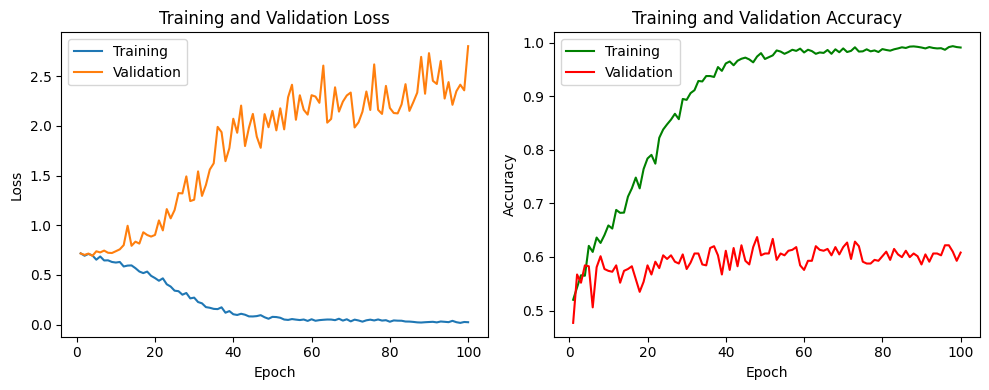

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_R.to(device)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(validation_data, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)


criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = optim.SGD(model_R.parameters(), lr=0.001, momentum=0.9)


num_epochs = 100
training_loss = []  
validation_loss = []
train_acc = []
validatoin_acc = []

#Training

for epoch in range(num_epochs):
    model_R.train()
    running_train_loss = 0.0
    train_correct = 0
    train_total = 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_R(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_loss = running_train_loss / len(train_loader)
    train_accuary = train_correct / train_total
    training_loss.append(train_loss)
    train_acc.append(train_accuary)


#Validation

    model_R.eval()
    running_val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for i,data in enumerate(val_loader,0):
            inputs,labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_R(inputs)
            val_loss = criterion(outputs,labels)
            running_val_loss += val_loss.item()

            _,predicted = torch.max(outputs,1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()


    val_loss = running_val_loss / len(val_loader)
    val_accuracy = val_correct / val_total
    validation_loss.append(val_loss)
    validatoin_acc.append(val_accuracy)
    

    print(f"Epoch {epoch+1}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuary*100:.2f}%, Validatoin Loss: {val_loss:.4f}, Validatoin Accuracy: {val_accuracy*100:.2f}%")
    if (epoch + 1) %  10 == 0:
        torch.save(model_R.state_dict(),f"Gender_model_V2_checkpoint_epoch_{epoch + 1}.pth")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), training_loss,label = 'Training')
plt.plot(range(1, num_epochs + 1), validation_loss,label = 'Validation')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_acc,color='g',label = 'Training')
plt.plot(range(1, num_epochs + 1), validatoin_acc,color='r',label = 'Validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


AUROC: 0.6222


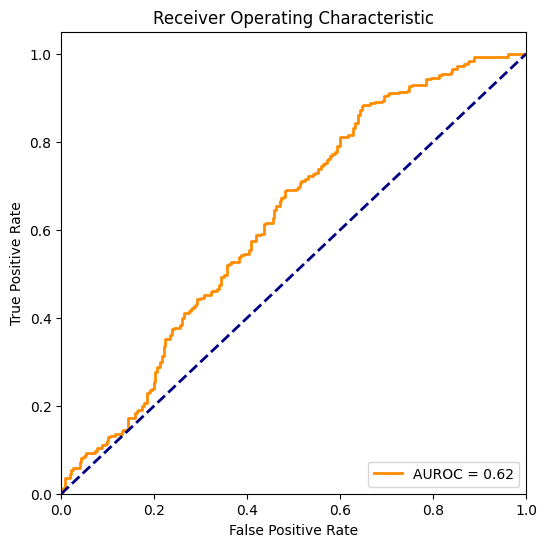

In [7]:
# validation

model_R.eval()
all_labels = [] 
all_scores = []  

with torch.no_grad():
    for i, data in enumerate(val_loader, 0):  # val_loader or train_loader
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_R(inputs)

        all_labels.extend(labels.cpu().numpy())  # real label
        all_scores.extend(outputs[:, 1].cpu().numpy())  # model predict score

# Calculate AUC
fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
auroc = auc(fpr, tpr)

print(f"AUROC: {auroc:.4f}")

# draw ROC
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUROC = {auroc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

AUROC: 0.7660


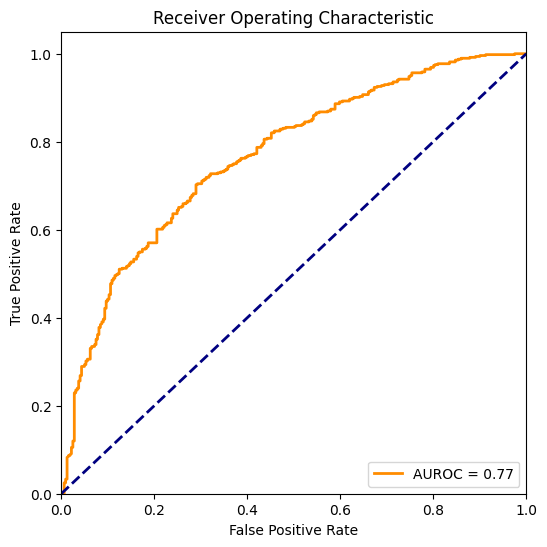

In [8]:
# Testing

model_R.eval()
all_labels = [] 
all_scores = []  

with torch.no_grad():
    for i, data in enumerate(test_loader, 0):  # val_loader or train_loader
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_R(inputs)

        all_labels.extend(labels.cpu().numpy())  # real label
        all_scores.extend(outputs[:, 1].cpu().numpy())  # model predict score

# Calculate AUC
fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
auroc = auc(fpr, tpr)

print(f"AUROC: {auroc:.4f}")

# draw ROC
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUROC = {auroc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()